# Dynamics of the Spin-Boson Model

## Overview

In this notebook we will simulate the dynamics of a 1-mode spin-boson model.

$$
    \hat H = \epsilon \hat \sigma_z + \Delta \hat \sigma_x + \omega \hat b^\dagger \hat b
              + g \sigma_z (\hat b^\dagger + \hat b)
$$

We will first start with implementing it from scratch, and then show how to use the `TimeEvolution` class for the very same task.

## Determine the model and basis

TenCirChem provides a simple yet versatile interface to define the Hamiltonian and the basis set.
The Hamiltonian operators are specified through a list of `Op` object and simple harmonic oscillator (SHO) basis set is used for the boson in the spin-boson model.
The relevant classes are borrowed from [Renormalizer](https://github.com/shuaigroup/Renormalizer).

In [1]:
from tencirchem import Op, BasisHalfSpin, BasisSHO

epsilon = 0
delta = 1
omega = 1
g = 0.5

ham_terms = [
    Op("sigma_z", "spin", epsilon),
    Op("sigma_x", "spin", delta),
    Op(r"b^\dagger b", "boson", omega),
    Op("sigma_z", "spin", g) * Op(r"b^\dagger+b", "boson"),
]
basis = [BasisHalfSpin("spin"), BasisSHO("boson", omega=omega, nbas=8)]
ham_terms, basis

([Op('sigma_z', ['spin'], 0.0),
  Op('sigma_x', ['spin'], 1.0),
  Op('b^\\dagger b', ['boson', 'boson'], 1.0),
  Op('sigma_z b^\\dagger+b', ['spin', 'boson'], 0.5)],
 [BasisHalfSpin(dof: spin, nbas: 2),
  BasisSHO(dof: boson, x0: 0.0, omega: 1, nbas: 8)])

`tencirchem.dynamic.model` offers several shotcuts for common models

Quantum circuit is not able to simulate the boson basis, and proper basis transform to qubit basis is required

In [2]:
# transform the Hamiltonian and basis
from tencirchem.dynamic import qubit_encode_op, qubit_encode_basis

boson_encoding = "gray"
ham_terms_spin, constant = qubit_encode_op(ham_terms, basis, boson_encoding)
basis_spin = qubit_encode_basis(basis, boson_encoding)
# boson basis is transformed to spin basis
ham_terms_spin, constant, basis_spin

([Op('X', ['spin'], 1.0),
  Op('Z', [('boson', 'TCCQUBIT-0')], -2.0),
  Op('Z Z', [('boson', 'TCCQUBIT-0'), ('boson', 'TCCQUBIT-1')], -1.0),
  Op('Z Z Z', [('boson', 'TCCQUBIT-0'), ('boson', 'TCCQUBIT-1'), ('boson', 'TCCQUBIT-2')], -0.5),
  Op('Z X', ['spin', ('boson', 'TCCQUBIT-2')], 0.9517337620166572),
  Op('Z Z X', ['spin', ('boson', 'TCCQUBIT-1'), ('boson', 'TCCQUBIT-2')], -0.040295934250509535),
  Op('Z Z X', ['spin', ('boson', 'TCCQUBIT-0'), ('boson', 'TCCQUBIT-2')], -0.26872106012443797),
  Op('Z Z Z X', ['spin', ('boson', 'TCCQUBIT-0'), ('boson', 'TCCQUBIT-1'), ('boson', 'TCCQUBIT-2')], -0.14271676764170976),
  Op('Z X', ['spin', ('boson', 'TCCQUBIT-1')], 0.4829629131445341),
  Op('Z X Z', ['spin', ('boson', 'TCCQUBIT-1'), ('boson', 'TCCQUBIT-2')], -0.4829629131445341),
  Op('Z Z X', ['spin', ('boson', 'TCCQUBIT-0'), ('boson', 'TCCQUBIT-1')], -0.12940952255126037),
  Op('Z Z X Z', ['spin', ('boson', 'TCCQUBIT-0'), ('boson', 'TCCQUBIT-1'), ('boson', 'TCCQUBIT-2')], 0.1294095225

## Construct ansatz

TenCirChem uses the variational Hamiltonian ansatz. Suppose the Hamiltonian has $N$ terms and is written as 

$$
\hat H = \sum_j^N \hat h_j
$$ 

The the variational Hamiltonian ansatz has the form
$$
| \psi \rangle = \prod_k^M \prod_j^N e^{-i \theta_{kj} \hat h_j} | \phi \rangle
$$

where $| \phi \rangle$ is the initial state, $\theta_{kj}$ is the circuit parameter and $M$ is number of layers for the ansatz.

In [3]:
import tensorcircuit as tc
from tencirchem import set_backend
from tencirchem.dynamic import get_ansatz, get_jacobian_func, get_deriv

# dynamics simulation requires auto-differentiation from JAX.
set_backend("jax")

# the initial state
init_circuit = tc.Circuit(len(basis_spin))
# number of layers
n_layers = 3
# get the ansatz. Note that the spin basis is feed in
ansatz = get_ansatz(ham_terms_spin, basis_spin, n_layers, init_circuit)

# ansatz accepts parameters and outputs wavefunction
import numpy as np

ansatz(np.zeros(n_layers * len(ham_terms_spin)))

DeviceArray([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j], dtype=complex128)

The jacobian matrix for the wavefunction $\partial | \psi \rangle / \partial \theta_{kj}$ is required to perform VQA dynamics based on TDVP. 

In [4]:
# the funcction to evaluate the jacobian of the wavefunction
jacobian_func = get_jacobian_func(ansatz)

Compute time derivative $\dot \theta$ based on McLachlan's variational principle

$$
 \textrm{Re} M  \theta =  \textrm{Im} V   
$$

Here $M$ is a matrix and $V$ is a vector

$$
M = \frac{\partial \langle \psi | }{\partial \theta_{kj}}  \frac{\partial | \psi \rangle }{\partial \theta_{k'j'}}
$$
$$
   V = \frac{\partial \langle \psi | }{\partial \theta_{kj}} | \hat H | \psi \rangle
$$

In [5]:
# the Hamiltonian in dense matrix format
from tencirchem import get_dense_operator

h = get_dense_operator(basis_spin, ham_terms_spin)


# time derivative for $\theta_{kj}$ in the scipy solve_ivp format
def scipy_deriv(t, _theta):
    return get_deriv(ansatz, jacobian_func, _theta, h)

## Run simulation

Use SciPy RK45 solver to solve the $\theta$ initial value problem (IVP). Calculate $\langle \hat \sigma_z \rangle$ for plotting.

In [6]:
from scipy.integrate import solve_ivp
from scipy.linalg import expm

# time step
tau = 0.1
# initial value
theta = np.zeros(n_layers * len(ham_terms_spin))
# operator to measure Z
z_op = get_dense_operator(basis_spin, Op("Z", "spin"))
z_list = [1]
# for reference
z_exact_list = [1]
for n in range(100):
    # time evolution
    scipy_sol = solve_ivp(scipy_deriv, [n * tau, (n + 1) * tau], theta)
    # time evolved parameter
    theta = scipy_sol.y[:, -1]
    # calculate expectation
    state = ansatz(theta)
    z_list.append((state.conj().T @ z_op @ state).real)
    state_exact = expm(-1j * (n + 1) * tau * h) @ init_circuit.state()
    z_exact_list.append((state_exact.conj().T @ z_op @ state_exact).real)

## Plot

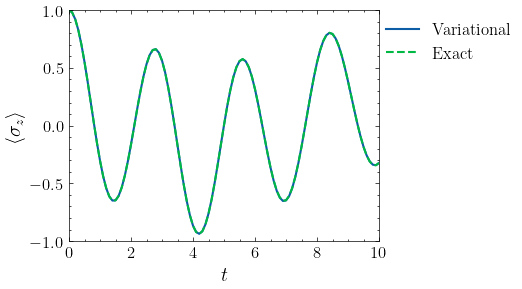

In [7]:
from matplotlib import pyplot as plt
import mpl_config

t = np.arange(101) * tau
plt.plot(t, z_list, label="Variational")
plt.plot(t, z_exact_list, linestyle="--", label="Exact")
plt.xlim(0, 10)
plt.ylim(-1, 1)
plt.xlabel("$t$")
plt.ylabel(r"$\langle \sigma_z \rangle$")
plt.legend(loc=(1, 0.75))

## Use ``TimeEvolution`` class
In this subsection we show how to use the ``TimeEvolution`` class to  greatly simplify the workflow.

In [8]:
from tencirchem import TimeEvolution

te = TimeEvolution(ham_terms_spin, basis_spin, property_op_dict={"Z": Op("Z", "spin")})
for i in range(100):
    te.kernel(tau)

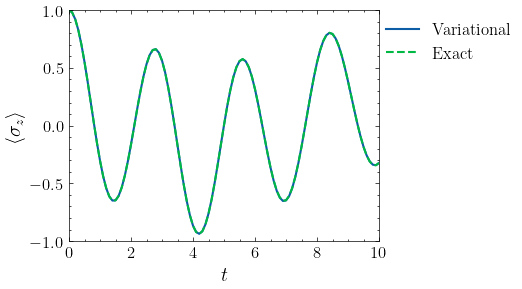

In [9]:
plt.plot(te.t_list, te.properties["Z"][:, 0].real, label="Variational")
plt.plot(te.t_list, te.properties["Z"][:, 1].real, linestyle="--", label="Exact")
plt.xlim(0, 10)
plt.ylim(-1, 1)
plt.xlabel("$t$")
plt.ylabel(r"$\langle \sigma_z \rangle$")
plt.legend(loc=(1, 0.75))
plt.savefig("sbm.pdf")